In [2]:
from datetime import datetime
from pytz import timezone

tz = timezone('EST')

print("Kernel is up")
print(datetime.now(tz))

Kernel is up
2019-01-26 23:42:37.455750-05:00


# WGAN-GP with DCGAN layers
Code is mainly based upon the DCGAN implementation in the TensorFlow tutorials

In [3]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
#import memory_saving_gradients
# monkey patch tf.gradients to point to our custom version, with automatic checkpoint selection
#tf.__dict__["gradients"] = memory_saving_gradients.gradients_memory
import librosa
import os
import functools
import subprocess
import time
import numpy as np
import matplotlib.pyplot as plt
#import PIL
#import imageio
#import simpleaudio as sa
import math
import gc
from IPython import display
import time
import scipy.io.wavfile as wavfile
from tensorflow.layers import dense, flatten
from tensorflow.nn import relu, leaky_relu
from tensorflow import tanh
from tensorflow.image import ResizeMethod
#from google.cloud import storage
#import google.auth
#from google.auth import compute_engine

resize_images = lambda x, size: tf.transpose(tf.image.resize_bilinear(tf.transpose(x, [0, 2, 3, 1]), size, align_corners=True), [0, 3, 1, 2])
conv2d_transpose = functools.partial(tf.layers.conv2d_transpose, padding='same', data_format='channels_first')
conv2d = functools.partial(tf.layers.conv2d, padding='same', data_format='channels_first')
batch_norm = functools.partial(tf.layers.batch_normalization, axis=1)
layer_norm = lambda x: tf.transpose(tf.contrib.layers.layer_norm(tf.transpose(x, [0, 2, 3, 1])), [0, 3, 1, 2])
pool = functools.partial(tf.nn.pool, window_shape=(2, 2), pooling_type='AVG', padding='SAME', data_format='NCHW')

In [4]:
def playAudio(audio, sr):
    audio = audio.astype(np.int16)
    play_obj = sa.play_buffer(audio, 1, 2, sr)
    play_obj.wait_done()

# Hyperparameters

In [5]:
# Number for large nsynth-train dataset
TOTAL_NUM = 102165
# Number for small nsynth-test dataset
# TOTAL_NUM = 1689
BUFFER_SIZE = 2048
BATCH_SIZE = 64
PREFETCH_BUFFER_SIZE = 2 * BATCH_SIZE
# EPOCHS = 150
LAMBDA = 10
ALPHA = 0.0002
BETA1 = 0.5
BETA2 = 0.999
CRITIC_UPDATES_PER_GEN_UPDATE = 5
noise_dim = 100
num_steps = 100
num_tpu = 1
num_examples_to_generate = 16
epoch_counter = 0
padded_spec_dim = (3, 128, 512)
spec_dim = (3, 128, 504)
epoch_proportion_counter = 0.0
model_dir = 'gs://jz-model-checkpoints/gan-tpu/'

# Defining models

In [6]:
def residBlockUpscale(num, x, num_filters, filter_size=5, strides=(2, 2), 
                      num_filters_intermed=None, training=True):
    with tf.variable_scope('resid-block-upscale-{}'.format(num)):
        if(num_filters_intermed is None):
            num_filters_intermed = num_filters
        x_orig = resize_images(x, (x.shape[2]*strides[0], x.shape[3]*strides[1]))
        x_orig = conv2d(x_orig, num_filters, 1, 1)
        x = batch_norm(x, training=training)
        x = relu(x)
        x = resize_images(x, (x.shape[2]*strides[0], x.shape[3]*strides[1]))
        x = conv2d(x, num_filters_intermed, filter_size, 1, use_bias=False)
        x = batch_norm(x, training=training)
        x = relu(x)
        x = conv2d(x, num_filters, filter_size, 1, use_bias=False)
        x = x_orig + x
        return x

def residBlockDownscale(num, x, num_filters, filter_size=5, strides=(2, 2), 
                        num_filters_intermed=None, training=True):
    with tf.variable_scope('resid-block-downscale-{}'.format(num)):
        if(num_filters_intermed is None):
            num_filters_intermed = num_filters
        x_orig = pool(x, window_shape=strides)
        x_orig = conv2d(x_orig, num_filters, 1, 1)
        x = layer_norm(x)
        x = relu(x)
        x = conv2d(x, num_filters_intermed, filter_size, 1)
        x = layer_norm(x)
        x = relu(x)
        x = conv2d(x, num_filters_intermed, filter_size, 1)
        x = pool(x)
        x = x_orig + x
        return x
    
def upsampleConvBatchNorm(num, x, num_filters, filter_size=5, strides=(2, 2), training=True):
    with tf.variable_scope('upsample-conv-batch-norm-{}'.format(num)):
        x = resize_images(x, (x.shape[2]*strides[0], x.shape[3]*strides[1]))
        x = conv2d(x, num_filters, filter_size, 1, use_bias=False)
        x = batch_norm(x, training=training)
        x = relu(x)
        return x

def convLayerNorm(num, x, num_filters, filter_size=5, strides=(2, 2), training=True):
    with tf.variable_scope('conv-layer-norm-{}'.format(num)):
        x = conv2d(x, num_filters, filter_size, strides=strides)
        x = layer_norm(x)
        x = leaky_relu(x)
        return x

In [7]:
def generator(x, batch_size, training=True):
    # Input x is noise vector
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
        if(callable(x)):
            x = x()
        # x_orig = tf.transpose(tf.image.resize_bicubic(tf.transpose(x, [0, 2, 3, 1]), 512*256), [0, 3, 1, 2])
        x = dense(x, 512*8*32)
        # MAKE SURE SHAPES ARE EQUAL, OR ELSE SIZE -1 WILL CAUSE BATCH SIZE MISMATCH
        x = tf.reshape(x, shape=(batch_size, 512, 8, 32))
        assert not(callable(x))
        x = upsampleConvBatchNorm(1, x, 512, filter_size=5, training=training)
        x = upsampleConvBatchNorm(2, x, 256, filter_size=5, training=training)
        x = upsampleConvBatchNorm(3, x, 128, filter_size=5, training=training)
        x = upsampleConvBatchNorm(4, x, 128, filter_size=5, training=training)
        x = batch_norm(x, training=training)
        x = relu(x)
        x = conv2d(x, 3, 5, 1)
        x = tanh(x)

        x = x[:, :, :, 0:spec_dim[2]]
        return x
    
def critic(x, batch_size, training=True):
    with tf.variable_scope('critic', reuse=tf.AUTO_REUSE):
        x = convLayerNorm(1, x, 128, strides=(1, 1), training=training)
        x = convLayerNorm(2, x, 128, training=training)
        x = convLayerNorm(3, x, 128, training=training)
        x = convLayerNorm(4, x, 256, training=training)
        x = convLayerNorm(5, x, 512, training=training)
        x = tf.reshape(x, shape=(batch_size, -1))
        x = dense(x, 1)
        return x

# Making a TPUEstimator

In [8]:
def record_parser(raw_data):
    read_features = {
            'note': tf.FixedLenFeature([], dtype=tf.int64),
            'note_str': tf.FixedLenFeature([], dtype=tf.string),
            'instrument': tf.FixedLenFeature([], dtype=tf.int64),
            'instrument_str': tf.FixedLenFeature([], dtype=tf.string),
            'pitch': tf.FixedLenFeature([], dtype=tf.int64),
            'velocity': tf.FixedLenFeature([], dtype=tf.int64),
            'sample_rate': tf.FixedLenFeature([], dtype=tf.int64),
            'spectrogram': tf.FixedLenFeature([193536], dtype=tf.float32),
            #'spectrogram': tf.FixedLenFeature([128512], dtype=tf.float32),
            'instrument_family': tf.FixedLenFeature([], dtype=tf.int64),
            'instrument_family_str': tf.FixedLenFeature([], dtype=tf.string),
            'instrument_source': tf.FixedLenFeature([], dtype=tf.int64),
            'instrument_source_str': tf.FixedLenFeature([], dtype=tf.string)
    }
    return tf.reshape(tf.parse_single_example(serialized=raw_data, features=read_features)['spectrogram'], spec_dim)

params = {
    'batch_size': BATCH_SIZE,
}

def input_fn(params):
    with tf.variable_scope('input-pipeline'):
        # Reading features of TFRecord file
        files = tf.data.Dataset.list_files('gs://jz-datasets/spec-files/*.tfrecord')
        specs = files.apply(tf.data.experimental.parallel_interleave(tf.data.TFRecordDataset, cycle_length=2))
        specs = specs.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=BUFFER_SIZE))
        # specs = specs.map(map_func=(lambda raw_data: tf.reshape(tf.parse_single_example(serialized=raw_data, features=read_features)['spectrogram'], spec_dim)), num_parallel_calls=-1)
        specs = specs.apply(tf.data.experimental.map_and_batch(
            map_func=lambda x: (record_parser(x), tf.zeros(params['batch_size'])), 
            num_parallel_calls=-1, 
            batch_size=params['batch_size'], 
            drop_remainder=True))
        specs = specs.prefetch(buffer_size=2*params['batch_size'])
        return specs
    
def model_fn(features, labels, mode, params):
    global_step = tf.train.get_or_create_global_step()
    with tf.variable_scope('runs'):
        real_images = features
        noise = tf.random_normal([params['batch_size'], noise_dim])
        random_vector_for_generation = tf.random_normal([params['batch_size'], noise_dim])
        fake_images = generator(noise, params['batch_size'])
        fake_images_for_prediction = generator(random_vector_for_generation, params['batch_size'], training=False)
        critic_real = critic(real_images, params['batch_size'])
        critic_fake = critic(fake_images, params['batch_size'])
        # keeping the random vector constant for generation (prediction) so
        # it will be easier to see the improvement of the gan.
        
    if mode == tf.estimator.ModeKeys.PREDICT:
        test_images = {
            'fake_images': fake_images_for_prediction,
            'real_images': features,
            'global_step': tf.tile(tf.reshape(global_step, [1, 1]), [params['batch_size'], 1])
        }
        return tf.contrib.tpu.TPUEstimatorSpec(mode, predictions=test_images)
    
    with tf.variable_scope('costs'):
            gen_cost = -tf.reduce_mean(critic_fake)
            critic_cost_naive = tf.reduce_mean(critic_fake)-tf.reduce_mean(critic_real)

            with tf.variable_scope('gradient-penalty'):
                alpha = tf.random_uniform(shape=[params['batch_size'], spec_dim[0], spec_dim[1], spec_dim[2]], minval=0., maxval=1.)
                differences = fake_images-real_images
                interpolates = real_images+(alpha*differences)
                gradients = tf.gradients(critic(interpolates, params['batch_size']), [interpolates])[0]
                slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
                gradient_penalty = tf.reduce_mean((slopes-1.)**2)
                critic_cost = critic_cost_naive + LAMBDA*gradient_penalty

            costs = {
                'gen_cost': gen_cost,
                'critic_cost': critic_cost
            }

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.contrib.tpu.TPUEstimatorSpec(mode, loss=0) # , eval_metric_ops=costs)

    if mode == tf.estimator.ModeKeys.TRAIN:
        with tf.variable_scope('optimizers'):
            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                gen_opt = tf.contrib.tpu.CrossShardOptimizer(tf.train.AdamOptimizer(ALPHA, BETA1, BETA2)).minimize(gen_cost, global_step=global_step, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='runs/generator'))
                critic_opt = tf.contrib.tpu.CrossShardOptimizer(tf.train.AdamOptimizer(ALPHA, BETA1, BETA2)).minimize(critic_cost, global_step=global_step, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='runs/critic'))
            opt = tf.cond(
                tf.equal(tf.mod(tf.train.get_or_create_global_step(), CRITIC_UPDATES_PER_GEN_UPDATE+1), CRITIC_UPDATES_PER_GEN_UPDATE+1), 
                lambda: gen_opt, 
                lambda: critic_opt
            )
        return tf.contrib.tpu.TPUEstimatorSpec(mode, loss=critic_cost, train_op=opt)

    return
    #return generator, gen_opt, critic_opt, real_images, test_images, ranEpoch, getEpoch, increment, merged, global_step

In [9]:
def testAudio(batch, prefix):
    specs = sess.run(batch)
    for i in range(specs.shape[0]):
        spec = specs[i]
        mag = spec[:, :, 0]
        angles = spec[:, :, 1]
        mag = ((mag+1)/2)*48-32
        angles = angles*math.pi
        ft =(np.exp(mag)-1.2664166e-14)*np.exp(1j*angles)
        newaudio = librosa.istft(ft, 512, 2048).astype(np.int16)
        #print('Generated audio')
        #print('Interval of audio: [{}, {}]'.format(np.amin(newaudio), np.amax(newaudio)))
        wavfile.write("audio/{}-{}.wav".format(prefix, i), 16000, newaudio)

In [10]:
def runOneEpoch(model, epoch_proportion=1):
    global epoch_counter
    start = time.time()
    
    model.train(input_fn, steps=num_steps)
    
    predictions = next(iter(model.predict(input_fn, yield_single_examples=False)))
    display.clear_output(wait=True)
    global_step = generate_images(predictions, source='fake')
    global_step = generate_images(predictions, source='real')
    print("Finished global step {}".format(global_step))
    # saving (checkpoint) the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time taken: {} sec'.format(time.time()-start))

In [11]:
def generate_images(images, source='fake', save=True):
    # make sure the training parameter is set to False because we
    # don't want to train the batchnorm layer when doing inference.
    
    if(source=='fake'):
        disp_images = images['fake_images']
    elif(source=='real'):
        disp_images = images['real_images']
    else:
        raise ValueError
    
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(disp_images[i, 0, :, :] * 127.5, cmap="magma", origin="lower", aspect="auto")
        plt.axis('off')
    if(save):
        plt.savefig('images/image_at_{}_{}.png'.format(images['global_step'][0, 0], source))
    plt.show()
    
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(disp_images[i, 1, :, :] * 127.5, cmap="magma", origin="lower", aspect="auto")
        plt.axis('off')
    plt.show()
    
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(disp_images[i, 2, :, :] * 127.5, cmap="magma", origin="lower", aspect="auto")
        plt.axis('off')
    plt.show()
    
    return images['global_step'][0, 0]

# Running the model

In [13]:
cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(
    tpu=["node1"], 
    zone="us-central1-f", 
    project="jz-cloud-test"
)

tpu_run_config = tf.contrib.tpu.RunConfig(
    cluster=cluster_resolver, 
    model_dir=model_dir,
    session_config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True),
    tpu_config=tf.contrib.tpu.TPUConfig(num_steps, 8)
)  

In [14]:
model = tf.contrib.tpu.TPUEstimator(
    model_fn=model_fn, 
    config=tpu_run_config, 
    use_tpu=True, 
    train_batch_size=BATCH_SIZE, 
    predict_batch_size=16,
)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_task_type': 'worker', '_save_checkpoints_steps': None, '_num_worker_replicas': 1, '_experimental_distribute': None, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_cluster': <tensorflow.contrib.cluster_resolver.python.training.tpu_cluster_resolver.TPUClusterResolver object at 0x7ff0571bbcc0>, '_service': None, '_session_config': allow_soft_placement: true
log_device_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      value: "10.12.1.3:8470"
    }
  }
}
, '_keep_checkpoint_max': 5, '_task_id': 0, '_tf_random_seed': None, '_global_id_in_cluster': 0, '_is_chief': True, '_protocol': None, '_device_fn': None, '_evaluation_master': 'grpc://10.12.1.3:8470', '_eval_distribute': None, '_train_distribute': None, '_tpu_config': TPUConfig(iterations_per_loop=100, num_shards=8, num_cores_per_replica=None, per_host_input_for_training=2, tpu_job_name=None, initi

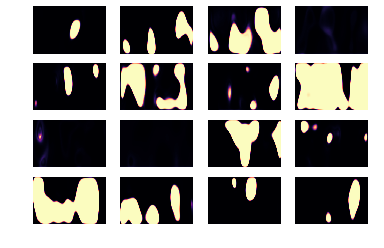

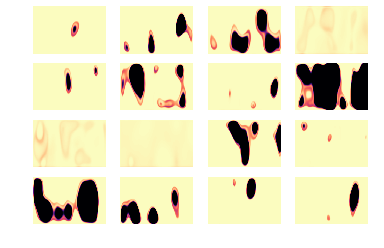

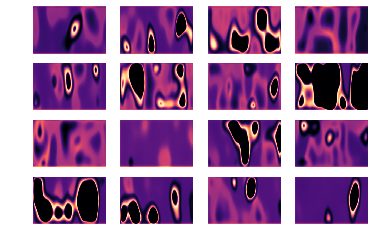

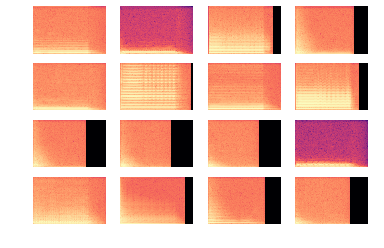

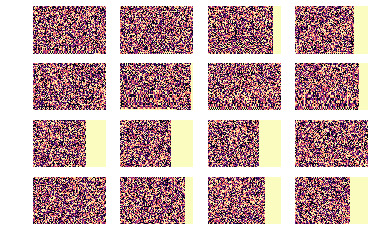

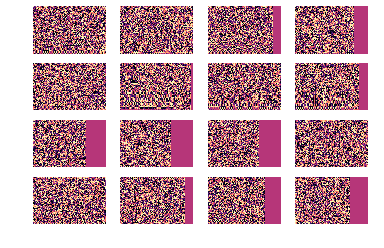

Finished global step 10000
Time taken: 337.2729916572571 sec
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:TPU job name worker
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from gs://jz-model-checkpoints/gan-tpu/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 10000 into gs://jz-model-checkpoints/gan-tpu/model.ckpt.
INFO:tensorflow:Initialized dataset iterators in 0 seconds
INFO:tensorflow:Installing graceful shutdown hook.
INFO:tensorflow:Creating heartbeat manager for ['/job:tpu_worker/replica:0/task:0/device:CPU:0']
INFO:tensorflow:Configuring worker heartbeat: shutdown_mode: WAIT_FOR_COORDINATOR

INFO:tensorflow:Init TPU system
INFO:tensorflow:Initialized TPU in 3 seconds
INFO:tensorflow:Starting infeed thread controller.
INFO:tensorflow:Starting outfeed thread controller.
INFO:te

In [ ]:
# Waits for another program to remove the .lock file before continuing execution
# !rm .lock
# Comment out next line to disable lock
# !touch .lock

while True:
    if(os.path.isfile('.lock')):
        break
    try:
        runOneEpoch(model)
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        print("Caught error")

print("Training stopped")

In [ ]:
print(sess.run(images).shape)

In [ ]:
testAudio(images, "real")
testAudio(generated, "fake")

In [ ]:
while(kernel is dead):
    plant_a_new_seed()